# Lab. TRIL - Carbon Capture and Storage

Engenharia Computacional para a Emissão Zero no Setor de Óleo e Gás

## Introdução 

Esse é um programa que realiza um processo de leitura, processamento e análise de um conjunto de dados de um reservatório, para encontrar classes de injetividade apresentadas com análise de gráfico.

Esse projeto é desenvolvido por:<br>
* Yhasmim de Souza Tigre - Aluna de Iniciação Científica - UFPB
* Prof. Dr. Gustavo C. Oliveira - Professor Orientador - UFPB


### Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
#%matplotlib inline 
#from matplotlib.pyplot import plotpip 

In [2]:
import warnings

#Serve para ignorar os 'red warnings' que algumas bibliotecas apontam porque tem novas versoes de implementacao
warnings.filterwarnings('ignore') 

## 1 - Preparação de Files 

Essas funções devem receber arquivos csv (em uma formatação pré-estabelecida) que serem lidos, checados e iniciados.<br>
Os arquivos precisam:
* ter colunas nomeadas 
* não ter valores NAN
* ter colunas na ordem correta (RQI, pressao, pressao_inversa, distancia, permeabilidade e porosidade)
* ter colunas com valores numéricos

In [83]:
def read_df(df, JN):
    """ função de leitura do arquivo csv para um dataframe corrigido
        
        parametro: df (csv) dataframe a ser lido
        retorno: df (pd.DataFrame)     
    """
    
    df = pd.read_csv(df)
    if any(df.isna()):
        print("df com valores NAN")
        
        df = df.fillna(0)
        print("df corrigido, não mais possui valores NAN")
   
    #remove values of 0
    df = df[(df.T != 0.00000).any()] #talvez seja necessario modificar, pode atrapalhar quando tiver outras colunas 
    #df = df.loc[(df!=0).any(axis=1)]
    print("df corrigido, não mais possui valores 0")

    #verifica se existem strings no df - aplicando a qualquer valor e retornando um boleano (true or false)
    is_string = df.applymap(lambda x: isinstance(x, str)).any().bool()

    if is_string == True:
    #corrigindo valores str para float 
        JN = {'J8'}
        for coluna in JN:                   
            df[f'{coluna}'] = df[f'{coluna}'].str.lower() #corrigindo str com valor 'e' maiusculo

            df[f'{coluna}']= df[f'{coluna}'].str.replace(',', '.') #corrigindo str com virgula invés de ponto
    
    #faz todos os valores serem float
    df = df.astype(float)
    
    #troca valores de -inf para 0
    df = df.replace(-np.inf, 0) 
    df = df[(df.T != 0.00000).any()]

    print(df)
    return df

In [4]:
'''função de checagem de keys em dataframe '''

def checking(df):
    
    df = read_df(df)

    lista_primarias = ['RQI','pressao','pressao_inversa','distancia','permeabilidade','porosidade']
    lista_Js = ['J1', 'J2', 'J3', 'J4', 'J5', 'J6', 'J7', 'J8']  
    
    #encontrando keys estrangeiras no df
    for i in df.keys():         
        if lista_primarias.count(i) == 0: 
            print(f'variavel estrangeira "{i}" incluída no Dataframe. Não identificada na lista de variaveis primarias. \n')                 
        if lista_Js.count(i) == 0:
            print(f'variavel estrangeira "{i}" incluída no Dataframe. Não identificada na lista de variaveis secundarias Js. \n')

    #encontrando keys faltantes no df
    for i in lista_primarias:  
        if list(df.keys()).count(i) == 0:
            print(f'variavel primaria "{i}" NÃO incluída no Dataframe. Não identificada na lista de variaveis primarias. \n')
    for i in lista_Js:  
        if list(df.keys()).count(i) == 0:
            print(f'variavel secundária "{i}" NÃO incluída no Dataframe. Não identificada na lista de variaveis secundária Js. \n')
        
    return df

## 2 - Calculo dos J's

Aqui criamos funções qualificadoras, que utilizam os atributos do df para categorizar J's.

In [130]:
'''função de normalização dos dados'''

def normalization(df, J, norm=False):

    #df = read_df(df)
    # df = checking(df)
    
    #atribuição        
    for j in J: 
              
        if j == 'J1':
            J1 = df['RQI']
            df['J1'] = J1
            normalize_(df, j, norm)            
                    
        if j == 'J2':
            J2 = df['RQI']*df['pressao']
            df['J2'] = J2
            normalize_(df, j, norm)

        if j == 'J3':
            J3 = df['RQI']*df['pressao_inversa']
            df['J3'] = J3
            normalize_(df, j, norm)                                                                                         
                            
        if j == 'J4':
            #para evitar resultados infinitos
            aux = np.log(df['distancia']) #calc do log(0 ind, 1 inf)
            #mascara
            aux[np.isinf(aux)] = 0 
            aux[np.isnan(aux)] = 0
            aux[aux < 0] = 0

            J4 = df['RQI'] * df['pressao'] * aux      
            df['J4'] = J4
            normalize_(df, j, norm) 

        if j == 'J5':

            aux = np.log(df['distancia'])
            aux[np.isinf(aux)] = 0 
            aux[np.isnan(aux)] = 0
            aux[aux < 0] = 0

            J5 = df['RQI'] * df['pressao_inversa'] * aux
            df['J5'] = J5
            normalize_(df, j, norm)
        
        if j == 'J6':

            aux = np.log(df['distancia'])
            aux[np.isinf(aux)] = 0 
            aux[np.isnan(aux)] = 0
            aux[aux < 0] = 0

            J6 = df['permeabilidade'] * df['porosidade'] * aux
            df['J6'] = J6
            normalize_(df, j, norm)  

    return df

def normalize_(df, col, norm):
    if norm == True:   
        df[f'{col}_normalizado'] = (df[col] - min(df[col])) / (max(df[col]) - min(df[col]))

## 3- Processamento Binning <br> (Bayesian Blocks ou KDE)
<br/>

A classe binning é responsável por processar os dados em KDE ou Bayesian Blocks 

#@jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit

In [ ]:
"""Processamento de dados em binning"""
class binning():

        #método construtor
        def __init__(self) -> None:
            pass
        
        #@jit(nopython=True)
        def proc_binning(df, JN, binning, tipo): 

            """
            parametros: 
                df - dataframe recebido de funções anteriores
                JN - lista dos nomes das colunas J ex: JN = {'J1_normalizado', 'J2_normalizado', 'J3_normalizado'}
                binning - tipo de binning a ser utilizado, podendo ser 'kde' ou 'bb'
                tipo - tipo de análise kde a ser realizada, podendo ser 'simplificado', 'unisim1' ou 'unisim2'

            retorno:
                
                """

            if binning == 'kde':

                import numpy as np
                from numpy import linspace
                from sklearn.neighbors import KernelDensity
                from scipy.signal import argrelmin, find_peaks
                from sklearn.model_selection import GridSearchCV, LeaveOneOut
                import scipy.integrate as integrate                        
                import matplotlib.pyplot as plt
                                
                '''Calculo kde'''
                
                ideal_band = 0
                for coluna in JN:                   
                    X = df[f'{coluna}'].values[::].reshape(-1, 1)
                    X = X[X > 0] 

                    band = np.linspace(0.01, 0.05)
                    grid = GridSearchCV(KernelDensity(), {'bandwidth': band},cv=LeaveOneOut(), n_jobs=-2)
                    #n_jobs vai fazer todos os nucleus da cpu trabalharem menos 2
                    
                    grid.fit(X[:,None].reshape(-1, 1)) 
                    ideal_band = grid.best_params_
                    #print("tamanho de banda ideal: ", ideal_band)  
                    #BANDWIDTH ORIGINAL: 0.01    


                '''Calculo kde'''
                resultados_kde = {}
                for coluna in JN:               
                    # faz o reshape para encaixar os dados em uma dimensão apropriada para o calculo 
                    X = df[f'{coluna}'].values[::]
                    X = X[X > 0].reshape(-1, 1) 
                        
                    # calculo da densidade de probabilidade
                    kde = KernelDensity(kernel='gaussian', bandwidth = ideal_band['bandwidth']).fit(X)

                #retorna os pontos em uma distancia determinada de 0 a 1 / os dados precisam está em 2D
                dist = np.linspace(0, 1.0, len(df[f'{coluna}']))
                #calcula a probabilidade logarítmica de cada amostra sob o modelo    
                log = kde.score_samples(dist.reshape(-1, 1))
                # usamos exponencial para deixar log positivo
                log = np.exp(log)
                
                '''Calculo integral'''
                #temos que calcular a integral para verificar se  o kde está correto para ser uma distribuição de probabilidade
                integral = float(np.exp(integrate.trapz(log[:, None], dist[:, None])).all())

                if integral <= 1.01 and integral >= 0.99:
                                    print(f'A integral : {integral} é adequeada.')
                else:
                    print(f'A integral não está no intervalo correto: {integral}')
                    raise KeyError(f'A integral precisa estar entre 0.99 e 1.01')  
                
                '''Calculo de picos e vales'''
                #retorna tupla com dois arrays, o primeiro com os indices dos picos e o segundo com os valores dos picos
                peaks = find_peaks(log)
                print(peaks)
                #Calcula a minima relativa dos dados
                valleys = argrelmin(log)[0]

                '''Calculo das classes'''
                #numero de classes = n-1 (numero dos dedos e espaço dentre os dedos= verdadeira classe)

                #uni os valores do valleys ordenados com 0 e 1 para encontrar os pontos de partição usando a minima relativa
                #ov = np.concatenate((np.array([0]), ordValleys_J, np.array([1])))

                con = np.concatenate((np.array([0.0]), dist[valleys], np.array([1.0])))
                #calcula a diferença entre os valores de con
                comp_classe = np.diff(con)
                #calcula o desvio padrão
                dp = np.std(comp_classe)    
                #excluindo classes com desvio padrao maior que o desvio padrão
                excl = np.where(comp_classe <= dp)

                #cria uma mascara para excluir os valores de con que estão fora do desvio padrão. True para manter e False para excluir
                mask = np.ones(con.shape,dtype=bool)
                mask[excl] = False
                con = con[mask]

                #como dicionario
                classes = {}
                for i in range(1, len(con)):
                    classes[i] = (con[i-1], con[i])

                #como lista
                cl = []
                for i in range(1, len(con)):
                    cl.append(con[i-1])
                cl.append(1.0)

                #salvando o dicionário classes como csv
                classes = pd.DataFrame(classes)
                classes.to_csv(f'classes_{coluna}_simplificado.csv', index=False)

                '''plot picos e valleys'''

                plt.figure(figsize=(10, 4))
                plt.plot(dist, log, color='seagreen', linewidth=2.5, alpha=0.3)  
                plt.fill_between(dist, log, color='seagreen', alpha=0.3)
                plt.plot(dist[valleys], log[valleys], "o", color='sienna')
                plt.plot(dist[peaks[0]], log[peaks[0]], "^", color='black')

                plt.xlabel(f'Posição de {coluna}', fontsize=15)
                plt.ylabel('Densidade', fontsize=15)
                plt.title(f'Picos e Vales | {coluna} normalizado', fontsize=20)
                plt.savefig(f'./dados/Analise de Js/simplificados/kde_simplificados/{coluna}_Simplificado_Picos_Vales.jpeg', format='jpeg')
                plt.show()

                '''plot kde '''

                plt.figure(figsize=(16, 10))
                plt.plot(dist, log, color='seagreen', linewidth=2.5, alpha=0.3)  
                plt.plot(dist[valleys], log[valleys], "o", color='sienna')
                #plt.plot(dist[peaks[0]], log[peaks[0]], "^", color='blue')

                #plot das classes como lista
                myList = classes.items()
                myList = sorted(myList)
                x, y = zip(*myList)

                plt.plot(y, log[:len(classes.columns)], 'x',markersize=10, color='peru')#log[num de colunas da classes]

                #criando linhas verticais para cada classe
                for i in range(1, len(cl)):
                    plt.axvline(cl[i], color='peru', linestyle='--')

                #para preencher as classes
                for i in range(1, len(cl)):
                    plt.fill_between(dist, 0, log, where=(dist >= cl[i-1]) & (dist <= cl[i]), color='seagreen', alpha=0.3)

                plt.xlabel(f'Posição de {coluna}', fontsize=15)
                plt.ylabel('Densidade', fontsize=15)

                if tipo == 'simplificado':
                    plt.title(f'Classificação do Kernel | {coluna} simplificado', fontsize=20)
                    plt.savefig(f'./dados/Analise de Js/simplificados/kde_simplificados/{coluna}_simplificado_Kernel.jpeg', format='jpeg')
                    plt.show()
                if tipo == 'unisim1':
                    plt.title(f'Classificação do Kernel | {coluna} unisim1', fontsize=20)
                    plt.savefig(f'./dados/Analise de Js/kde_unisim/{coluna}_Unisim1_Kernel.jpeg', format='jpeg')
                    plt.show()
                if tipo == 'unisim2':
                    plt.title(f'Classificação do Kernel | {coluna} unisim2', fontsize=20)
                    plt.savefig(f'./dados/Analise de Js/kde_unisim/{coluna}_Unisim2_Kernel.jpeg', format='jpeg')
                    plt.show()

                #retorno de funcão KDE como dicionario
                resultados_kde[coluna] = {}
                
                resultados_kde[coluna]['dist'] = dist
                resultados_kde[coluna]['log'] = log
                resultados_kde[coluna]['peaks'] = peaks
                resultados_kde[coluna]['valleys'] = valleys
                resultados_kde[coluna]['classes'] = classes

                return resultados_kde  

            if binning == 'bb':
                 
                from astropy.stats import bayesian_blocks

                """
                Essa funcao tem como objetivo criar uma representação gráfica
                de uma determinada 'coluna' de um determinado DataFrame (df)
                dado o calculo de seus bins/classes baseados no Bayesian Blocks.
                Pode-se obter os Bayesian Blocks de uma determinada variável
                usando a funcao 'bayesian_blocks' do módulo astropy.stats
                """

                def grafico_bb(df, JN, bins_bb, coluna):
                    
                    labels = {
                        "J1_normalizado" : "RQI",
                        "J2_normalizado" : "RQI * Pressao",
                        "J3_normalizado" : "RQI * Pressao Inversa",
                        "J4_normalizado" : "RQI * Pressao * ln(distancia)",
                        "J5_normalizado" : "RQI * Pressao Inversa * ln(distancia)", 
                        "J6_normalizado" : "Permeabilidade * Porosidade * ln(distancia)",
                        "J7_normalizado" : "ln(Permeabilidade) * ln(Porosidade) * ln(distancia)"
                    }
                    
                    ax = plt.figure(figsize=(20, 12))
                    ax = plt.title(f'Histograma {JN} utilizando blocos bayesianos', fontsize = 24)
                    #ax = plt.title(f"Histograma '{coluna} = {labels[coluna]}' utilizando blocos bayesianos", fontsize = 24)
                    ax = plt.xlabel("X", fontsize = 18)
                    ax = plt.ylabel("Y", fontsize = 18)
                    ax = plt.hist(df, bins = bins_bb, color='seagreen', alpha=0.3)
                    ax = plt.grid(True)
                    plt.savefig(f'./dados/Analise de Js/simplificados/bb_simplificados/{coluna}_Bayesian.jpeg', format='jpeg')
                    plt.show(ax)

                    resultados = {}

                    for coluna in df.columns:
                        if coluna in df.columns[0]:
                            serie = df.query(f"{coluna} > 0")[coluna]
                            resultados[coluna] = [serie, bayesian_blocks(serie)]
                            grafico_bb(resultados[coluna][0], resultados[coluna][1], coluna)
                             

In [73]:
'''Adição do padding '''

def padding(df, J):

    #df = binning.proc_binning(df, J, binning='kde')

    padDF = np.pad(df, (1, 1)) #para a melhor localização de pontos divisores de classe
    return padDF    

## 4 - Pickle

In [8]:
def pickle (df, fileout):
    import pickle as pkl 

# Testes


In [4]:
import numpy as np
from numpy import linspace
from sklearn.neighbors import KernelDensity
from scipy.signal import argrelmin, find_peaks
from sklearn.model_selection import GridSearchCV, LeaveOneOut
import scipy.integrate as integrate                        
import matplotlib.pyplot as plt
#import seaborn as sns
#import plotly.graph_objects as go
#import plotly.express as px

In [ ]:
df = read_df("./dados/Simplificados_unisim-i-d/yhasmim_J8.csv", 'J8')
#df = read_df("./dados/Simplificados_unisim-i-d/J2_reduzido.csv")
#df = read_df("./dados/unisim-ii-d/J8_UNISIM2.csv", 'J8') #j2 tem string
#df = df.sample(1500)

df com valores NAN
df corrigido, não mais possui valores NAN
df corrigido, não mais possui valores 0
            J8
2344  0.206040
2345  0.208010
2346  0.227120
2347  0.266150
2348  0.193850
...        ...
8068  0.000102
8072  0.116440
8073  0.009565
8076  0.194120
8077  0.051454

[4667 rows x 1 columns]


In [85]:
ideal_band = 0
#JN = {'J1_normalizado', 'J2_normalizado', 'J3_normalizado', 'J4_normalizado', 'J5_normalizado', 'J6_normalizado'}
JN =  {'J8'}
#df = normalization (df, JN, norm=True)

for coluna in JN:                   
    X = df[f'{coluna}'].values[::].reshape(-1, 1)
    X = X[X > 0] 

    band = np.linspace(0.01, 0.05)
    grid = GridSearchCV(KernelDensity(), {'bandwidth': band},cv=LeaveOneOut(), n_jobs=-2
                        
                        
                        )#n_jobs vai fazer todos os nucleus da cpu trabalharem menos 2
    grid.fit(X[:,None].reshape(-1, 1)) 
    ideal_band = grid.best_params_
    #print(ideal_band)  
    #BANDWIDTH ORIGINAL: 0.01    
    #j2 - 80m

In [8]:
#novo metodo para gridsearch mais rápido: tune-sklearn
from tune_sklearn import TuneGridSearchCV
JN =  {'J3'}

for coluna in JN:                   
    X = df[f'{coluna}'].values[::].reshape(-1, 1)
    X = X[X > 0] 

    band = np.linspace(0.01, 0.05)
    tune_search = TuneGridSearchCV(KernelDensity(), {'bandwidth': band},cv=LeaveOneOut(),early_stopping="MedianStoppingRule",n_jobs=-3)
    tune_search.fit(X[:,None].reshape(-1, 1))
    ideal_band_tune_search = tune_search.best_params_
    #problema de import da biblioteca


KeyError: 'J3'

In [9]:
print(ideal_band) 

{'bandwidth': 0.01}


In [86]:
'''Calculo kde'''
resultados_kde = {}
#JN={"J2"}

for coluna in JN:                    
    
    # faz o reshape para encaixar os dados em uma dimensão apropriada para o calculo 
    X = df[f'{coluna}'].values[::]
    X = X[X > 0].reshape(-1, 1) 
           
    # calculo da densidade de probabilidade
    kde = KernelDensity(kernel='gaussian', bandwidth = ideal_band['bandwidth']).fit(X)

In [87]:
dist = np.linspace(0, 1.0, len(df[f'{coluna}']))

In [88]:
log = kde.score_samples(dist.reshape(-1, 1))
log = np.exp(log)                 

In [90]:
#temos que calcular a integral para verificar se  o kde está correto para ser uma distribuição de probabilidade
integral = float(np.exp(integrate.trapz(log[:, None], dist[:, None])).all())

if integral <= 1.01 and integral >= 0.99:
                    print(f'A integral : {integral} é adequeada.')
else:
    print(f'A integral não está no intervalo correto: {integral}')
    raise KeyError(f'A integral precisa estar entre 0.99 e 1.01')                                        

A integral : 1.0 é adequeada.


In [91]:
#retorna tupla com dois arrays, o primeiro com os indices dos picos e o segundo com os valores dos picos
peaks = find_peaks(log)
print(peaks)
#Calcula a minima relativa dos dados
valleys = argrelmin(log)[0]
print(valleys)
print(type(valleys))

(array([ 901, 1652, 4219], dtype=int64), {})
[1398 4076 4443]
<class 'numpy.ndarray'>


In [134]:
#Retorna os indices que classificam o array e calcula o valores absolutos das diferenças entre os valores dos vales e ordena em ordem crescente
"""ord = np.argsort(np.abs(np.diff(log[valleys])))
print(ord)
#inverte a ordem do array 
ordValleys_J = np.flip(ord)+1 
print(ordValleys_J)"""

'ord = np.argsort(np.abs(np.diff(log[valleys])))\nprint(ord)\n#inverte a ordem do array \nordValleys_J = np.flip(ord)+1 \nprint(ordValleys_J)'

In [93]:
#numero de classes = n-1 (numero dos dedos e espaço dentre os dedos= verdadeira classe)

#uni os valores do valleys ordenados com 0 e 1 para encontrar os pontos de partição usando a minima relativa
#ov = np.concatenate((np.array([0]), ordValleys_J, np.array([1])))

con = np.concatenate((np.array([0.0]), dist[valleys], np.array([1.0])))
#calcula a diferença entre os valores de con
comp_classe = np.diff(con)
#calcula o desvio padrão
dp = np.std(comp_classe)    
#excluindo classes com desvio padrao maior que o desvio padrão
excl = np.where(comp_classe <= dp)

#cria uma mascara para excluir os valores de con que estão fora do desvio padrão. True para manter e False para excluir
mask = np.ones(con.shape,dtype=bool)
mask[excl] = False
con = con[mask]

print(type(con))
print(con)

#como dicionario
classes = {}
for i in range(1, len(con)):
    classes[i] = (con[i-1], con[i])
print(classes)


#como lista
cl = []
for i in range(1, len(con)):
    cl.append(con[i-1])
cl.append(1.0)
print(cl)

<class 'numpy.ndarray'>
[0.         0.29961423 1.        ]
{1: (0.0, 0.29961423060437203), 2: (0.29961423060437203, 1.0)}
[0.0, 0.29961423060437203, 1.0]


In [94]:
classes = pd.DataFrame(classes)
classes

,1,2
0,0.000000,0.299614
1,0.299614,1.000000


In [95]:
#criar csv para salvar as classes in a pasta
classes.to_csv(f'classes_{coluna}_simplificado.csv', index=False)

In [21]:
"""#calculo do valor de cada classe
cl = pd.read_csv('classes_J1_reduzido.csv')
cl = cl.T[2] -
d = []

#calculo do delta
for i in cl.columns:
    delta = cl[i].iloc[1] - cl[i].iloc[0] #delta - numpy.float64

    d.append(delta)

print(d)

#delta_classes = pd.DataFrame(d, columns= cl.columns)
#print(delta_classes)

#df.dif

cl.columns
"""

[0.2208180911207183, 0.15630196208846028, 0.11872297971400064, 0.2770202859993348, 0.22713668107748597]


Index(['1', '2', '3', '4', '5'], dtype='object')

In [33]:
n = classes.T[1] - classes.T[0]

n
classes['2'] = n

In [34]:
classes

,1,2,3,4,5,2
0,0.000000,0.220818,0.377120,0.495843,0.772863,NaN
1,0.220818,0.377120,0.495843,0.772863,1.000000,0.220818


In [23]:
print(dist.shape, log.shape, dist[valleys].shape, log[valleys].shape)

(37679,) (37679,) (0,) (0,)


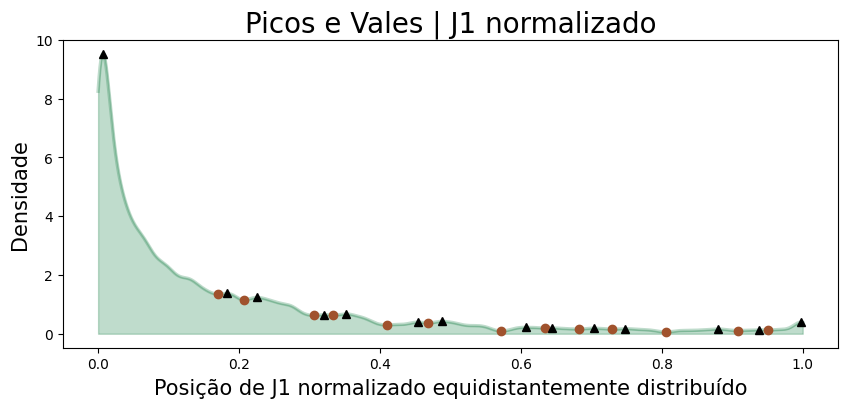

In [19]:
plt.figure(figsize=(10, 4))
plt.plot(dist, log, color='seagreen', linewidth=2.5, alpha=0.3)  
plt.fill_between(dist, log, color='seagreen', alpha=0.3)
plt.plot(dist[valleys], log[valleys], "o", color='sienna')
plt.plot(dist[peaks[0]], log[peaks[0]], "^", color='black')

plt.xlabel(f'Posição de {coluna} normalizado equidistantemente distribuído', fontsize=15)
plt.ylabel('Densidade', fontsize=15)
plt.title(f'Picos e Vales | {coluna} normalizado', fontsize=20)
plt.savefig(f'./dados/Analise de Js/simplificados/kde_simplificados/{coluna}_Simplificado_Picos_Vales.jpeg', format='jpeg')
plt.show()


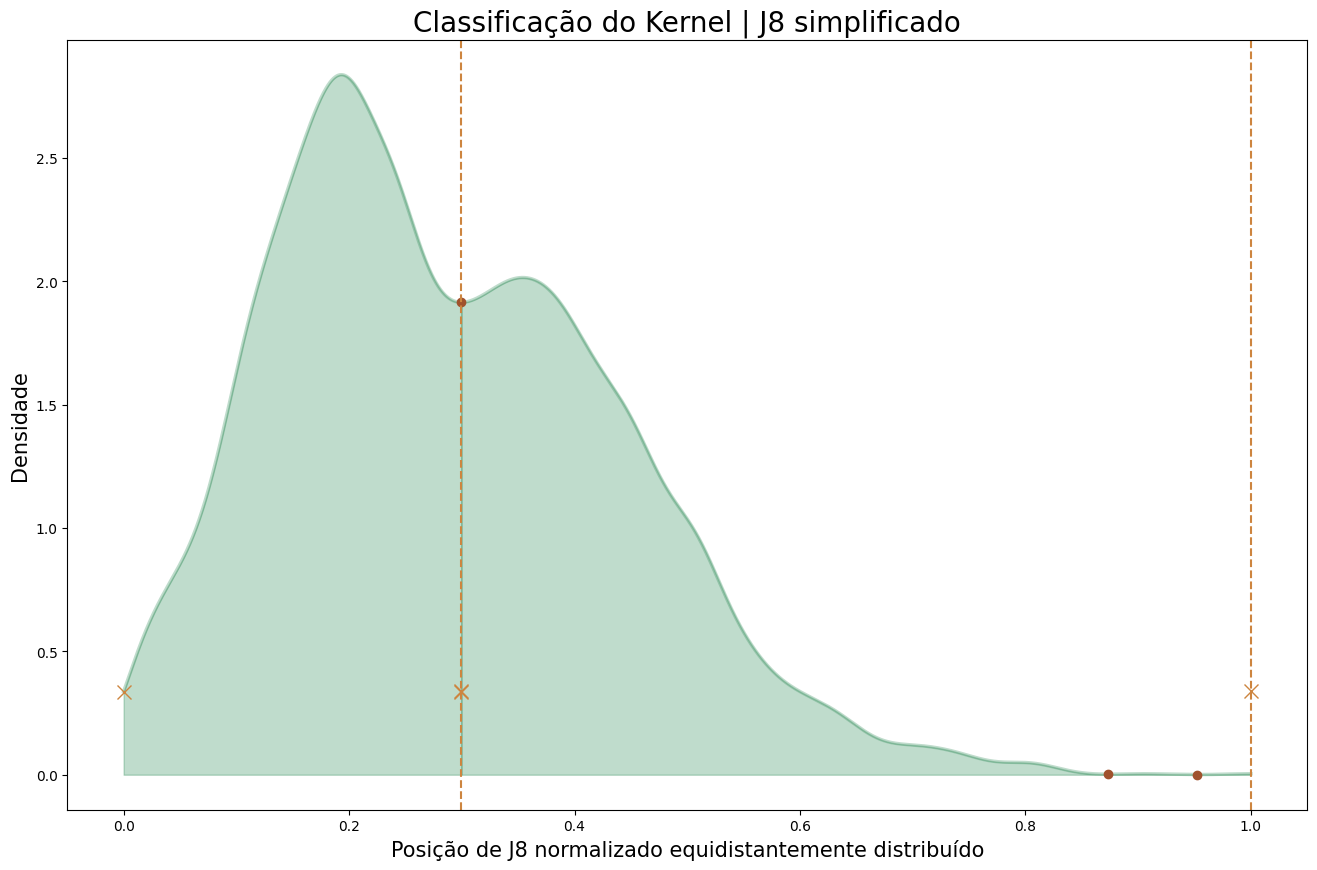

In [96]:
plt.figure(figsize=(16, 10))
plt.plot(dist, log, color='seagreen', linewidth=2.5, alpha=0.3)  
plt.plot(dist[valleys], log[valleys], "o", color='sienna')
#plt.plot(dist[peaks[0]], log[peaks[0]], "^", color='blue')

#plot das classes como lista
myList = classes.items()
myList = sorted(myList)
x, y = zip(*myList)

plt.plot(y, log[:len(classes.columns)], 'x',markersize=10, color='peru')#log[num de colunas da classes]

#criando linhas verticais para cada classe
for i in range(1, len(cl)):
    plt.axvline(cl[i], color='peru', linestyle='--')

#para preencher as classes
for i in range(1, len(cl)):
    plt.fill_between(dist, 0, log, where=(dist >= cl[i-1]) & (dist <= cl[i]), color='seagreen', alpha=0.3)

plt.xlabel(f'Posição de {coluna} normalizado equidistantemente distribuído', fontsize=15)
plt.ylabel('Densidade', fontsize=15)
plt.title(f'Classificação do Kernel | {coluna} simplificado', fontsize=20)
plt.savefig(f'./dados/Analise de Js/simplificados/kde_simplificados/{coluna}_simplificado_Kernel.jpeg', format='jpeg')
#plt.savefig(f'./dados/Analise de Js/kde_unisim/{coluna}_Unisim1_Kernel.jpeg', format='jpeg')
#plt.savefig(f'./dados/Analise de Js/kde_unisim/{coluna}_Unisim2_Kernel.jpeg', format='jpeg')
plt.show()


#BB

In [19]:
from astropy.stats import bayesian_blocks

coluna = {'J3'}

"""
Essa funcao tem como objetivo criar uma representação gráfica
de uma determinada 'coluna' de um determinado DataFrame (df)
dado o calculo de seus bins/classes baseados no Bayesian Blocks.
Pode-se obter os Bayesian Blocks de uma determinada variável
usando a funcao 'bayesian_blocks' do módulo astropy.stats
"""

def grafico_bb(df, bins_bb, coluna):
    
    labels = {
        "J1_normalizado" : "RQI",
        "J2_normalizado" : "RQI * Pressao",
        "J3_normalizado" : "RQI * Pressao Inversa",
        "J4_normalizado" : "RQI * Pressao * ln(distancia)",
        "J5_normalizado" : "RQI * Pressao Inversa * ln(distancia)", 
        "J6_normalizado" : "Permeabilidade * Porosidade * ln(distancia)",
        "J7_normalizado" : "ln(Permeabilidade) * ln(Porosidade) * ln(distancia)"
    }
    
    ax = plt.figure(figsize=(20, 12))
    ax = plt.title(f'Histograma {JN} utilizando blocos bayesianos', fontsize = 24)
    #ax = plt.title(f"Histograma '{coluna} = {labels[coluna]}' utilizando blocos bayesianos", fontsize = 24)
    ax = plt.xlabel("X", fontsize = 18)
    ax = plt.ylabel("Y", fontsize = 18)
    ax = plt.hist(df, bins = bins_bb, color='seagreen', alpha=0.3)
    ax = plt.grid(True)
    plt.savefig(f'./dados/Analise de Js/simplificados/bb_simplificados/{coluna}_Bayesian.jpeg', format='jpeg')
    plt.show(ax)


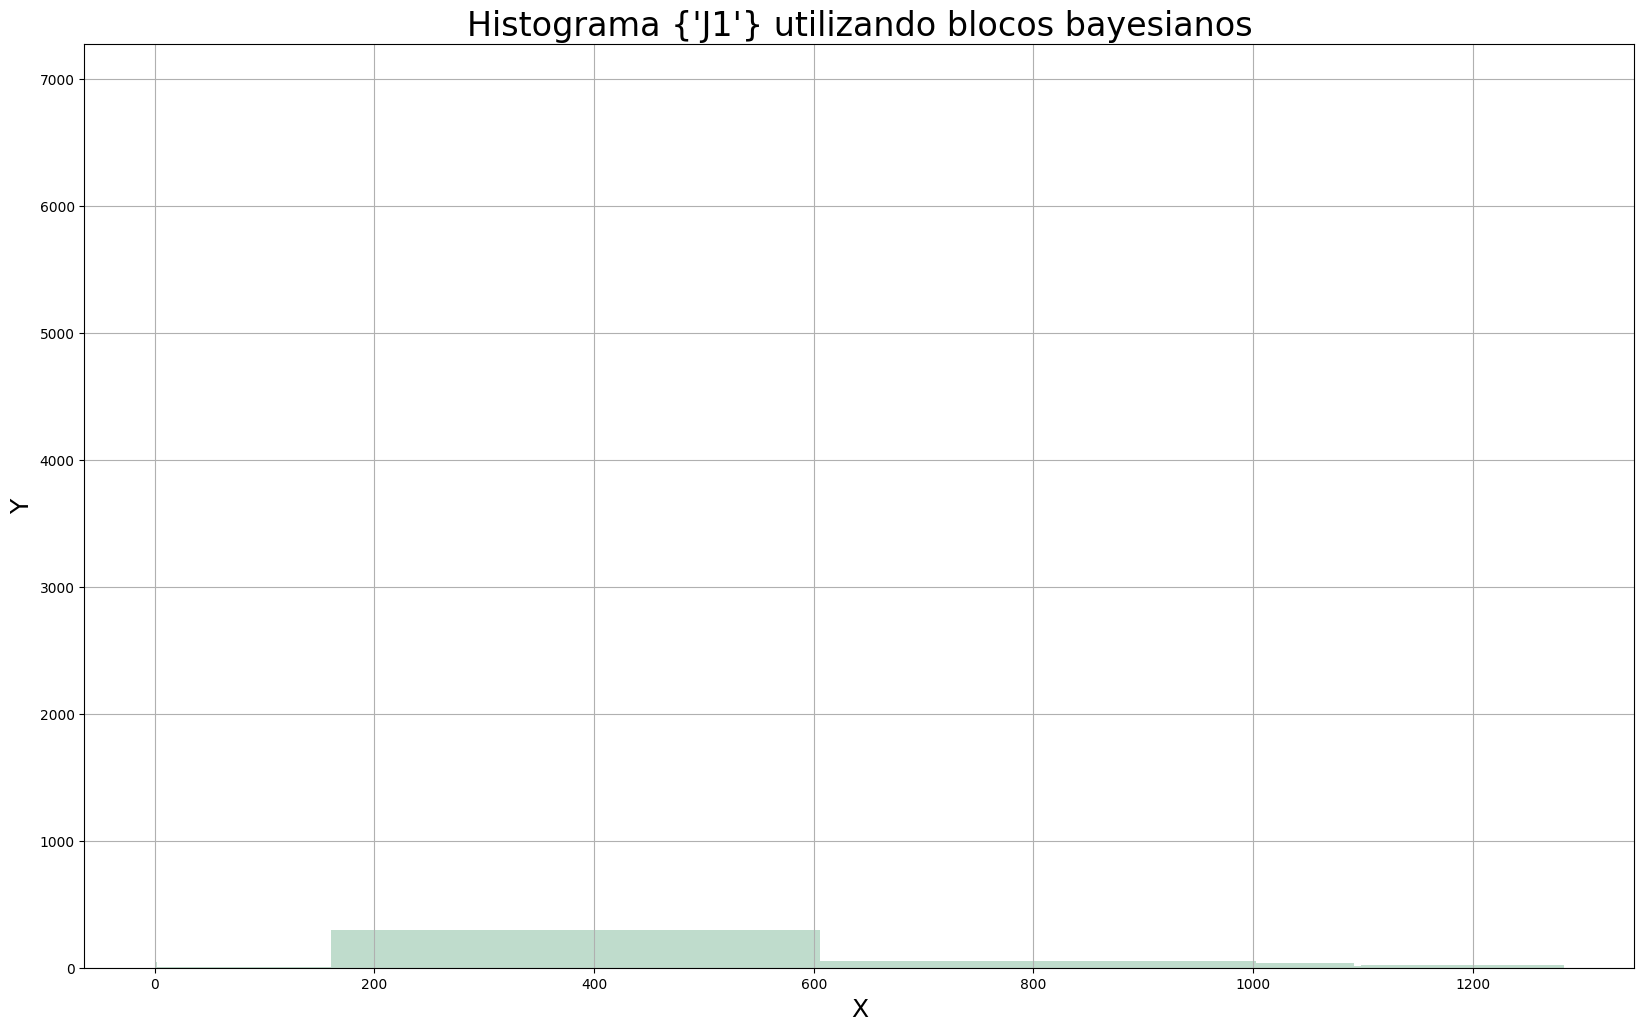

In [20]:
resultados = {}

for coluna in df.columns:
    if coluna in df.columns[0]:
        serie = df.query(f"{coluna} > 0")[coluna]
        resultados[coluna] = [serie, bayesian_blocks(serie)]
        grafico_bb(resultados[coluna][0], resultados[coluna][1], coluna)